In [2]:
import torch
from torch import nn

/Users/ramanghimire/opt/anaconda3/envs/anacondaX/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Classifier(nn.Module):
    
    def __init__(self):
        super(Classifier, self).__init__()
        self.fnn = nn.Sequential(
            nn.BatchNorm1d(42632),
            nn.Linear(42632,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,86),
        )
        
    def forward(self, X):
        return self.fnn(X)

In [4]:
classifier =  Classifier()

### Import Dataset from DDI

In [5]:
#Obtaining Dataset
from tdc.multi_pred import DDI
data = DDI(name = 'DrugBank')
split = data.get_split()

Found local copy...
Loading...
Done!


#### Remove all the data that are not present in our encoded molecular formula

In [6]:
import os
mol_dataset_dir = os.path.join(os.path.join(os.getcwd()), 'image_encoded_data')
all_filenames = os.listdir(mol_dataset_dir)
all_encoded = set([x.split(".")[0].strip() for x in all_filenames])

In [7]:
rows_to_be_removed = []
for count, value in split["train"].iterrows():
    if(value["Drug1_ID"]not in all_encoded or value["Drug2_ID"]not in all_encoded):
        rows_to_be_removed.append(count)
split["train"].drop(rows_to_be_removed,inplace=True)

rows_to_be_removed = []
for count, value in split["test"].iterrows():
    if(value["Drug1_ID"]not in all_encoded or value["Drug2_ID"]not in all_encoded):
        rows_to_be_removed.append(count)
split["test"].drop(rows_to_be_removed,inplace=True)

### Create a Dataset for training the classifier

In [8]:
import os
import PIL
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset


In [9]:
class EncodedDrugData(Dataset):
    def __init__(self, setname ):
        self.setname = setname
        assert setname in ['train','test']
        self.overall_dataset_dir = os.path.join(os.path.join(os.getcwd()), 'image_encoded_data')
        self.all_filenames = os.listdir(self.overall_dataset_dir)
        split[self.setname].reset_index()
        self.iter_data = split[self.setname]

    
    def __len__(self):
        return len(split[self.setname])
        
    def __getitem__(self, idx):
        current_data  = self.iter_data.iloc[idx,:]
        drug1 = torch.load(self.overall_dataset_dir+"/"+current_data["Drug1_ID"]+".pt")
        drug2 = torch.load(self.overall_dataset_dir+"/"+current_data["Drug2_ID"]+".pt")
        sample = {'data':torch.stack((drug1,drug2)).flatten(), #preprocessed image, for input into NN
                  'label':torch.tensor(current_data["Y"]-1),
                  'img_idx':idx}
        return sample

In [10]:
encoded_drug_data = EncodedDrugData("train")

#### Samples from the final dataset

In [11]:
iter_encoded_drug_data  = iter(encoded_drug_data)
next(iter_encoded_drug_data)

{'data': tensor([ 0.3689,  0.3689,  0.3689,  ..., -0.9818, -0.9818, -0.9818],
        grad_fn=<ReshapeAliasBackward0>),
 'label': tensor(0),
 'img_idx': 0}

### Train the classifier

In [12]:
from torch.utils.data import DataLoader

In [13]:
data_classifier_train = EncodedDrugData("train")
data_classifier_test = EncodedDrugData("test")

data_train = DataLoader(data_classifier_train, batch_size = 1024, shuffle = True)
data_test = DataLoader(data_classifier_test, batch_size = 1024, shuffle = True)

### Loss function

In [15]:
# Validation using CrossEntropy Loss function
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr = 1e-2)
epochs = 5

In [16]:
def accuracy(predicted, actual):
    predicted = predicted.detach().numpy()
    actual = actual.detach().numpy()
    x =  (np.argmax(predicted,axis = 1) == actual).sum()/len(actual)
    return x

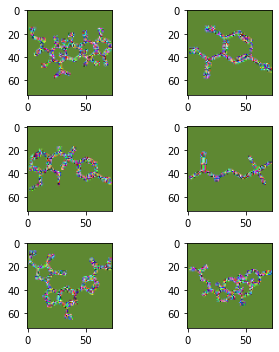

In [53]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
Im_show = ToPILImage()
a = torch.load('image_encoded_data//DB13747.pt')[0][0:3]
b = torch.load('image_encoded_data//DB00006.pt')[0][0:3]
c = torch.load('image_encoded_data//DB00150.pt')[0][0:3]
d = torch.load('image_encoded_data//DB00035.pt')[0][0:3]
e = torch.load('image_encoded_data//DB00080.pt')[0][0:3]
f = torch.load('image_encoded_data//DB00115.pt')[0][0:3]


fig, axs = plt.subplots(3,2, figsize =(5,5))
plt.subplots_adjust(hspace = 0, wspace = 0)
axs[0][0].imshow(Im_show(a))
axs[0][1].imshow(Im_show(b))
axs[1][0].imshow(Im_show(c))
axs[1][1].imshow(Im_show(d))
axs[2][0].imshow(Im_show(e))
axs[2][1].imshow(Im_show(f))
fig.tight_layout()

In [18]:
test_accuracy = []
train_accuracy = []
train_loss = []
test_loss = []
for epoch in range(epochs):
    for i, data in enumerate(data_train):
        optimizer.zero_grad()
    
        output = classifier(data["data"])
        
        print("output",(np.argmax(output.detach().numpy(),axis=1)== data["label"].detach().numpy()).sum())
        loss = loss_function(output, data["label"])
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()
        train_accuracy.append(accuracy(output,data["label"]))
        print(train_accuracy[-1])


        for j, data in enumerate(data_test):
            optimizer.zero_grad()
            output_test = classifier(data["data"])
            test_accuracy.append(accuracy(output_test, data["label"]))
            loss  = loss_function(output_test, data['label'])
            test_loss.append(loss.item())
            if j > 0:
                break
    if train_accuracy[-1] > 0.75:
        break
    torch.save(classifier.state_dict(),'Classifier_state_dict.pt')
    print('Epoch: ',epoch,"Training accuracy: ",train_accuracy[-1], "Testing accuracy",test_accuracy[-1])


output 592
0.578125
output 610
0.595703125
output 572
0.55859375
output 615
0.6005859375
output 606
0.591796875
output 612
0.59765625
output 608
0.59375
output 621
0.6064453125
output 606
0.591796875
output 604
0.58984375
output 615
0.6005859375
output 616
0.6015625
output 624
0.609375
output 590
0.576171875
output 643
0.6279296875
output 629
0.6142578125
output 607
0.5927734375
output 615
0.6005859375
output 614
0.599609375
output 583
0.5693359375
output 610
0.595703125
output 591
0.5771484375
output 612
0.59765625
output 650
0.634765625
output 631
0.6162109375
output 639
0.6240234375
output 645
0.6298828125
output 617
0.6025390625
output 578
0.564453125
output 634
0.619140625
output 632
0.6171875
output 633
0.6181640625
output 630
0.615234375
output 630
0.615234375
output 663
0.6474609375
output 641
0.6259765625
output 590
0.576171875
output 628
0.61328125
output 617
0.6025390625
output 625
0.6103515625
output 654
0.638671875
output 635
0.6201171875
output 636
0.62109375
output 627
0

In [90]:
# Performance Metrics
# !pip install sklearn
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay

Text(0.5, 1.0, 'Accuracy versus Episode - Test and Train')

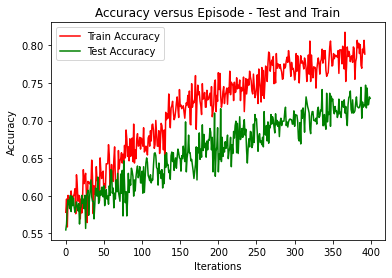

In [68]:
fig,axs = plt.subplots()
axs.plot(np.array(train_accuracy), c = 'r', label = 'Train Accuracy')
axs.plot(np.array(test_accuracy)[0:400], c = 'g', label = 'Test Accuracy')
axs.legend()
axs.set_xlabel('Iterations')
axs.set_ylabel('Accuracy')
axs.set_title('Accuracy versus Episode - Test and Train')


Text(0.5, 1.0, 'Loss versus Episode - Test and Train')

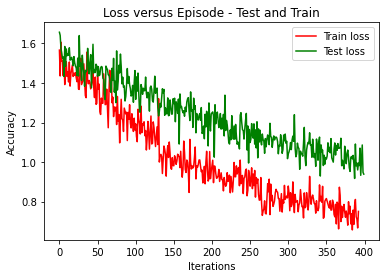

In [69]:
fig,axs = plt.subplots()
axs.plot(np.array(train_loss), c = 'r', label = 'Train loss')
axs.plot(np.array(test_loss)[0:400], c = 'g', label = 'Test loss')
axs.legend()
axs.set_xlabel('Iterations')
axs.set_ylabel('Accuracy')
axs.set_title('Loss versus Episode - Test and Train')


(30,)
(30,)


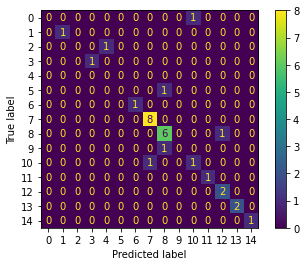

In [84]:
a  = next(iter(data_train))
classifier.eval()
pred_output = np.argmax(classifier(a['data']).detach().numpy()[0:30],axis = 1)
actual = a['label'].detach().numpy()[0:30]
print(actual.shape)
print(pred_output.shape)
cnf_matrix = confusion_matrix(actual,pred_output)
disp = ConfusionMatrixDisplay(cnf_matrix)
disp.plot()
plt.show()


In [89]:
f_score = f1_score(actual,pred_output,average='micro')

(1024,)
(1024,)


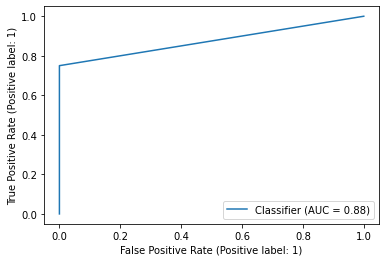

In [135]:
# a  = next(iter(data_train))
pred_output = np.argmax(classifier(a['data']).detach().numpy(),axis = 1)
actual = a['label'].detach().numpy()
print(actual.shape)
print(pred_output.shape)

pred = []
act = []

for i in range(len(actual)):
    if actual[i] == 26:
        act.append(1)
        if pred_output[i] == 26:
            pred.append(1)
        else:
            pred.append(0)
    else:
        act.append(0)
        if pred_output[i] == 26:
            pred.append(1)
        else:
            pred.append(0)

RocCurveDisplay.from_predictions(act,pred)


### Reference
1. @article{Huang2021tdc,
  title={Therapeutics Data Commons: Machine Learning Datasets and Tasks for Drug Discovery and Development},
  author={Huang, Kexin and Fu, Tianfan and Gao, Wenhao and Zhao, Yue and Roohani, Yusuf and Leskovec, Jure and Coley, 
          Connor W and Xiao, Cao and Sun, Jimeng and Zitnik, Marinka},
  journal={Proceedings of Neural Information Processing Systems, NeurIPS Datasets and Benchmarks},
  year={2021}
}
<br>

2. https://tdcommons.ai/functions/data_process/
3. https://tdcommons.ai/functions/data_split/